### **Load Environment variables from .env file**

In [18]:
from openai import AzureOpenAI
from dotenv import load_dotenv
import os
from IPython.display import display, HTML, JSON, Markdown, Image
import requests

load_dotenv()

GPT4o_API_KEY = os.getenv("GPT4o_API_KEY")
GPT4o_DEPLOYMENT_ENDPOINT = os.getenv("GPT4o_DEPLOYMENT_ENDPOINT")
GPT4o_DEPLOYMENT_NAME = os.getenv("GPT4o_DEPLOYMENT_NAME")
DVLA_API_KEY = os.getenv("DVLA_API_KEY")

client = AzureOpenAI(
  azure_endpoint = GPT4o_DEPLOYMENT_ENDPOINT, 
  api_key=GPT4o_API_KEY,  
  api_version="2024-02-01"
)

In [19]:
def call_openAI(text):
    response = client.chat.completions.create(
        model=GPT4o_DEPLOYMENT_NAME,
        messages = text,
        temperature=0.0
    )
    return response.choices[0].message.content

### **Image input**  
Load image and show preview

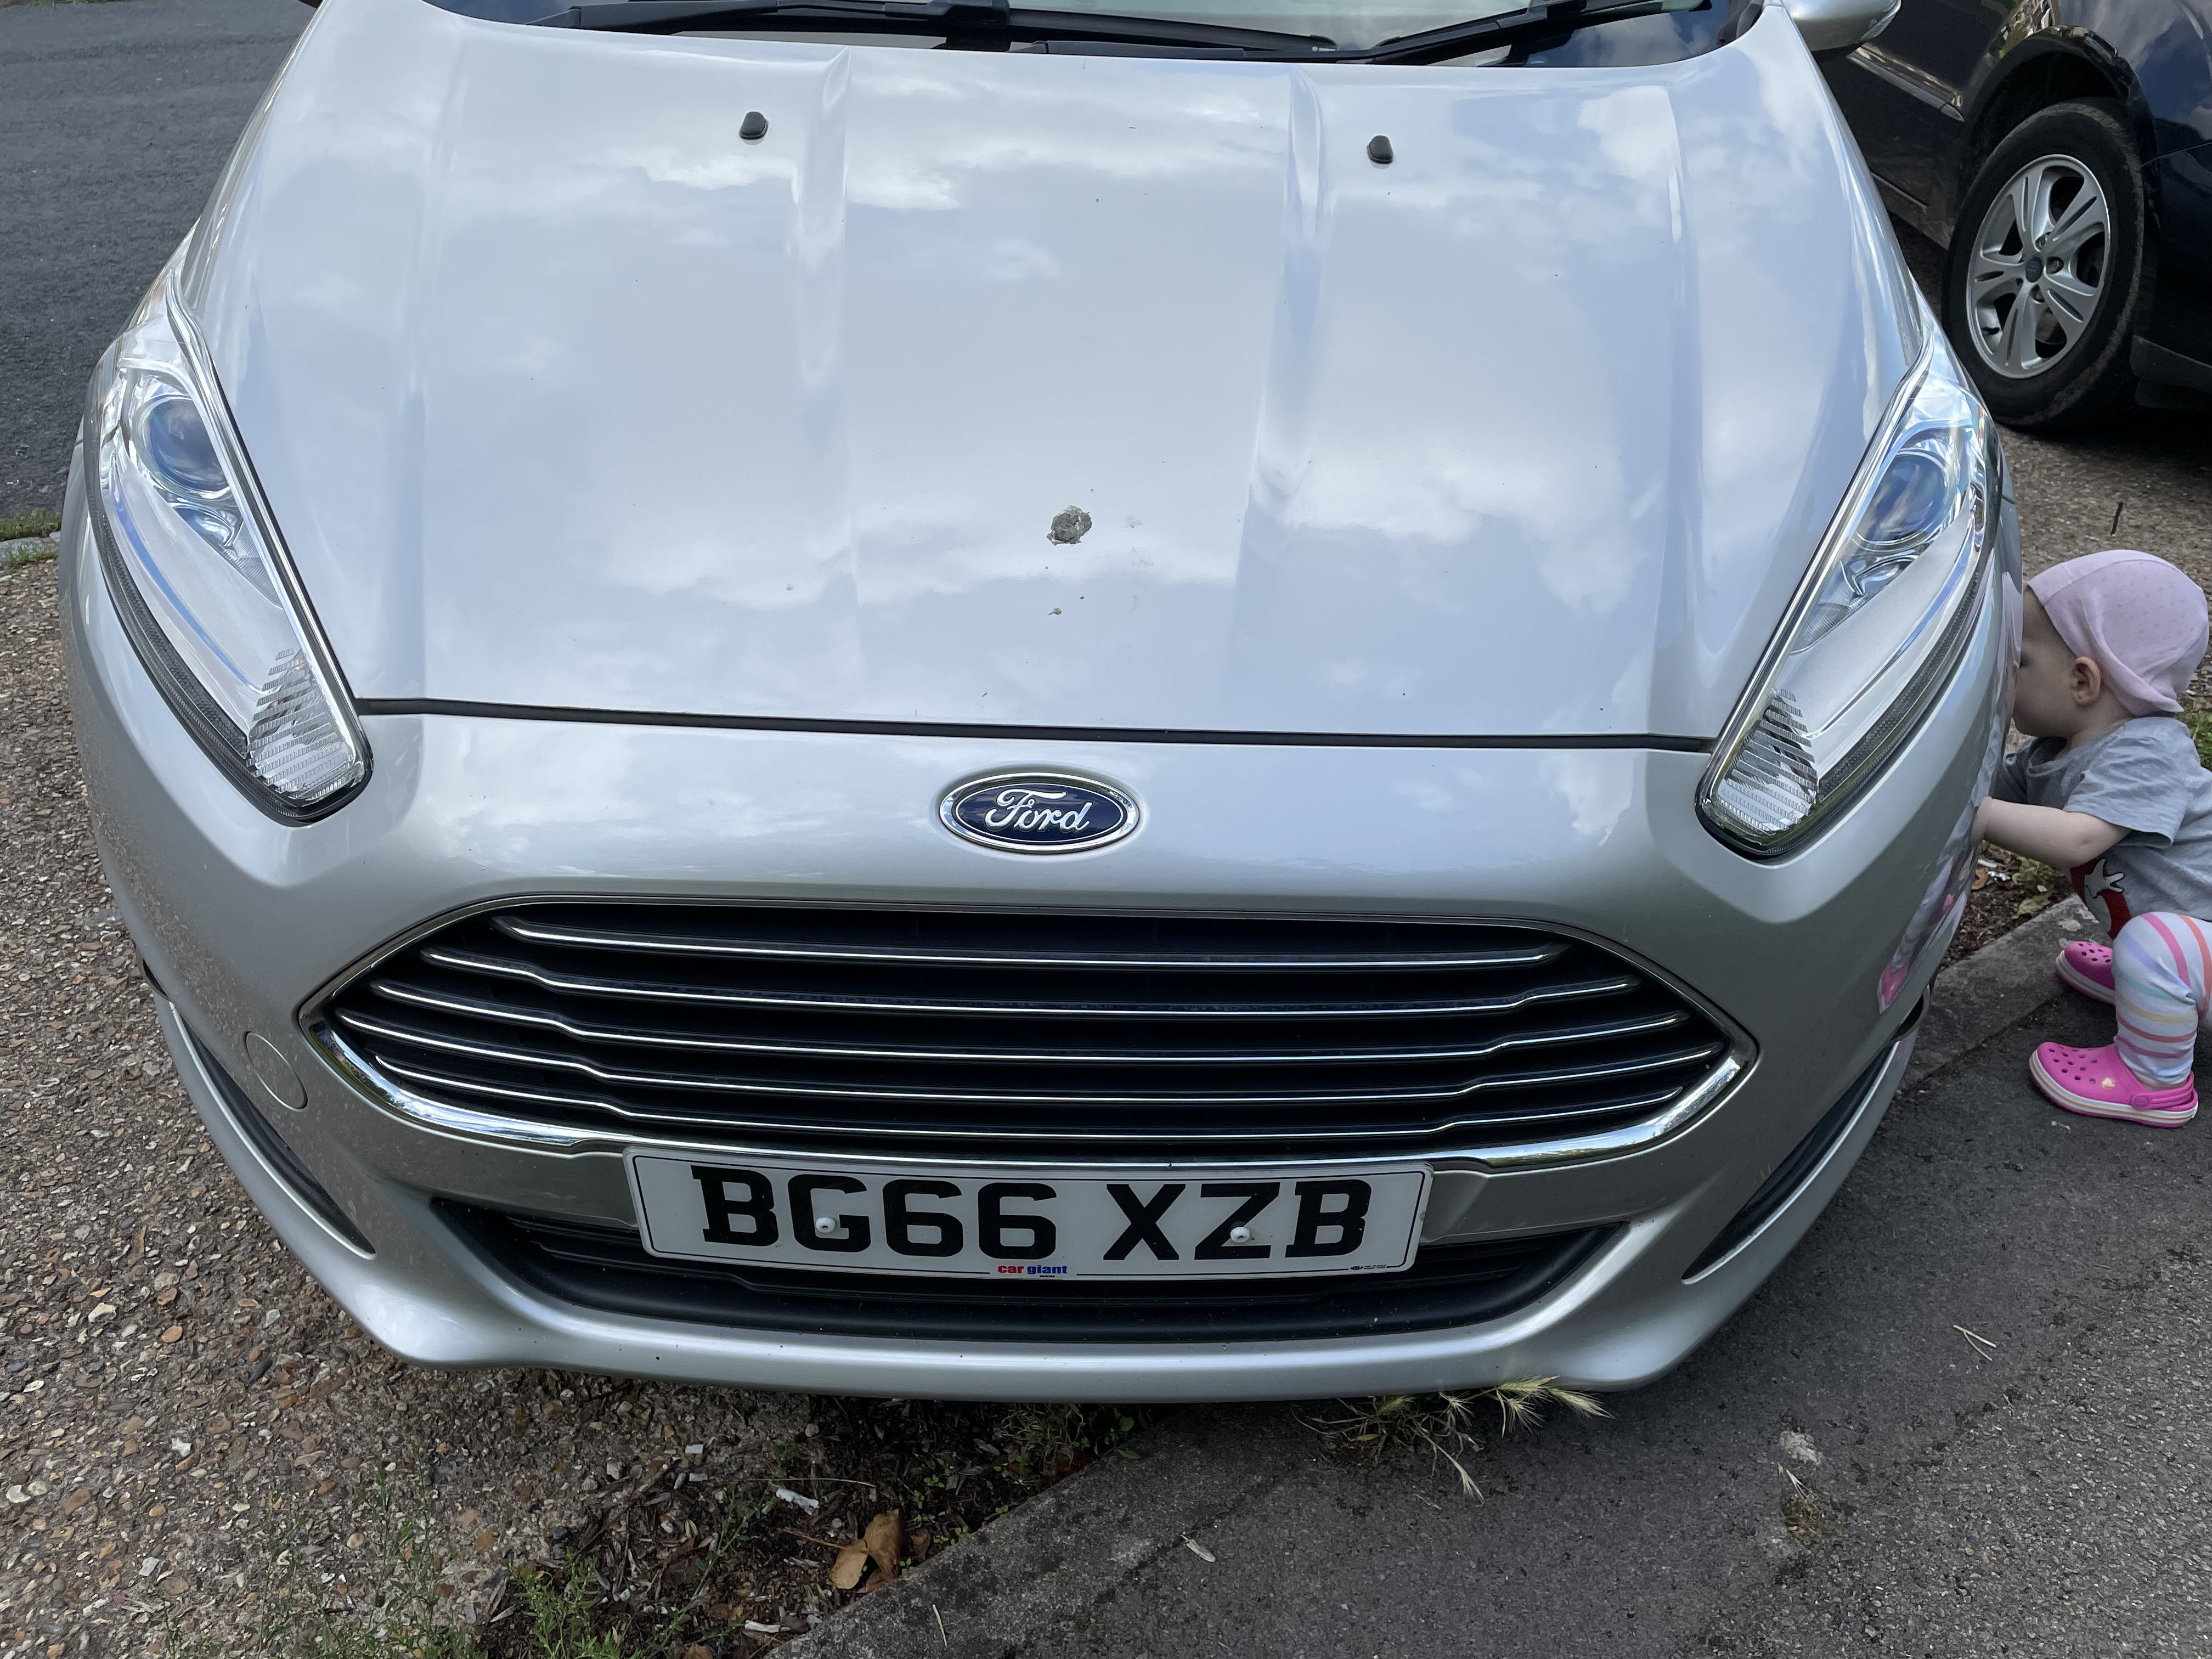

In [20]:
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

IMAGE_PATH = "./data/Car1.jpg"
base64_image = encode_image(IMAGE_PATH)
# Preview image for context
display(Image(IMAGE_PATH))

### **Summarise the car description**  
Use GPT-4o to return a JSON object

In [21]:
messages=[
    {"role": "system", "content": "You are a helpful assistant that explains the car in the image to the user. Return a JSON object."},
    {"role": "user", "content": [
        {"type": "text", "text": "What is the make, model, colour, registration, body_type, features"},
        {"type": "image_url", "image_url": {
            "url": f"data:image/png;base64,{base64_image}"}
        }
    ]}
]

resultCar = call_openAI(messages)
display(HTML(resultCar))



### **Extract just the registration plate**  
Use GPT-4o to return only the registration plate

In [22]:
messages=[
    {"role": "system", "content": "You are a helpful assistant that explains the car in the image to the user."},
    {"role": "user", "content": [
        {"type": "text", "text": "what is the car registration plate? Return only the registration plate number."},
        {"type": "image_url", "image_url": {
            "url": f"data:image/png;base64,{base64_image}"}
        }
    ]}
]

registrationPlate = call_openAI(messages)
display(HTML(registrationPlate))

### **Query the DVLA database via API**  
Let's fetch the details of the car from the DVLA using the registration plate

In [23]:
url = "https://driver-vehicle-licensing.api.gov.uk/vehicle-enquiry/v1/vehicles"

payload = f'{{\n\t"registrationNumber": "{registrationPlate}"\n}}'
headers = {
  'x-api-key': DVLA_API_KEY,
  'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, data = payload)

print(response.text.encode('utf8'))

b'{"registrationNumber":"BG66XZB","taxStatus":"Taxed","taxDueDate":"2024-10-01","motStatus":"Valid","make":"FORD","yearOfManufacture":2016,"engineCapacity":998,"co2Emissions":99,"fuelType":"PETROL","markedForExport":false,"colour":"SILVER","typeApproval":"M1","revenueWeight":1555,"dateOfLastV5CIssued":"2020-02-18","motExpiryDate":"2024-10-30","wheelplan":"2 AXLE RIGID BODY","monthOfFirstRegistration":"2016-10"}'


### **Provide a natural language summary**  
Using both the information from the DVLA and the description from the image, summarise the vehicle using GPT-4o

In [24]:
messages=[
    {"role": "system", "content": "You are a helpful assistant that provides a comprehensive natural language description of a car. Read all the information, merge it together, and then provide a clear description to the user."},
    {"role": "user", "content": [
        {"type": "text", "text": f"{resultCar}"f"{response.text}"},
    ]}
]

description = call_openAI(messages)
display(HTML(description))



### **Write the copy for an advert**  
Use GPT-4o to write a description to sell the car

In [25]:
messages=[
    {"role": "system", "content": "You are a helpful assistant that writes the job advert for a car showroom. Read all the information, merge it together, and then provide a few paragraphs of descriptive sales text to be included for the car advert. Don't mention the car's registration plate."},
    {"role": "user", "content": [
        {"type": "text", "text": f"{resultCar}"f"{response.text}"},
    ]}
]

description = call_openAI(messages)
display(HTML(description))

